In [1]:
!pip install google_play_scraper
!pip install textblob
from google_play_scraper import app
import pandas as pd
import numpy as np
import sklearn
import requests
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import seaborn as sns
import textblob
#from wordcloud import WordCloud
from pathlib import Path
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report, accuracy_score

import pickle
import re
import time
import datetime                              # access to %%time, for timing individual notebook cells
import os
from PIL import Image
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

%matplotlib inline
%config InlineBackend.figure_format='retina'

plt.style.use('seaborn')
plt.rcParams["figure.figsize"] = (15,10)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.2 MB/s eta 0:00:00


<ipython-input-1-9ccb641008d5>:31: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [2]:
#Android App YesDok link from Google Play at
#https://play.google.com/store/apps/details?id=com.yesdok.mobile.app&hl=id
#The apps ID found in the link after id=com.yesdok.mobile.app&hl=id
#The apps name on Google Play titled: YesDok by YesDok
#Dated 8 September 2024: number of reviews 16k

from google_play_scraper import app, Sort, reviews_all

yesdok_reviews = reviews_all(
    'com.yesdok.mobile.app',
    sleep_milliseconds=0, # defaults to 0
    lang='en', # defaults to 'en'
    sort=Sort.NEWEST, # defaults to Sort.MOST_RELEVANT
)

In [3]:
#Save the YesDok app reviews into dataframe
df_yesdokrev = pd.DataFrame(np.array(yesdok_reviews),columns=['content'])
df_yesdokrev = df_yesdokrev.join(pd.DataFrame(df_yesdokrev.pop('content').tolist()))
df_yesdokrev.to_csv(r'E:\KULIAH\df_yesdokrev.csv', index=False)
df_yesdokrev.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,0ebb1170-31cd-42af-a363-66d7e0dfa16e,Richie M,https://play-lh.googleusercontent.com/a-/ALV-U...,Very limited insurance integration options,3,0,None,2024-08-23 08:48:42,None,NaT,None
1,39ca4d4f-5701-4f0e-a5dd-ca1f069ea679,Annaf Rehn,https://play-lh.googleusercontent.com/a-/ALV-U...,So hard,1,0,12.2.5,2024-08-18 00:29:56,None,NaT,12.2.5
2,f2710436-cb2e-4cf5-a2ad-38ee3d143498,agung anugrah,https://play-lh.googleusercontent.com/a-/ALV-U...,bagus,5,0,12.2.2,2024-05-26 08:38:47,None,NaT,12.2.2
3,7b9b70a5-0a33-47e3-8aee-f4930705b630,Ryandi W,https://play-lh.googleusercontent.com/a-/ALV-U...,Saya nggak bisa login asuransi saya di app ini,1,0,12.2.1,2024-03-14 02:53:19,"Dear Kak Ryandi, mohon maaf atas kendala yang ...",2024-03-18 08:21:11,12.2.1
4,04e64c25-d538-40c5-b8d0-beea25f51408,Albert Wibowo,https://play-lh.googleusercontent.com/a-/ALV-U...,Hati2 dokter2 disini..konsultasi krn positif c...,1,0,12.1.4,2024-01-27 14:33:52,"Dear Kak Albert Satryo Wibowo, Mohon maaf atas...",2024-03-18 08:32:07,12.1.4


In [5]:
#Information on the table
df_yesdokrev.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1767 entries, 0 to 1766
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   reviewId              1767 non-null   object        
 1   userName              1767 non-null   object        
 2   userImage             1767 non-null   object        
 3   content               1767 non-null   object        
 4   score                 1767 non-null   int64         
 5   thumbsUpCount         1767 non-null   int64         
 6   reviewCreatedVersion  1260 non-null   object        
 7   at                    1767 non-null   datetime64[ns]
 8   replyContent          253 non-null    object        
 9   repliedAt             253 non-null    datetime64[ns]
 10  appVersion            1260 non-null   object        
dtypes: datetime64[ns](2), int64(2), object(7)
memory usage: 152.0+ KB


In [6]:
print(df_yesdokrev.reviewCreatedVersion.unique())
print(df_yesdokrev.reviewCreatedVersion.nunique())

[None '12.2.5' '12.2.2' '12.2.1' '12.1.4' '11.2.6' '11.1.6' '11.1.3'
 '11.1.0' '11.0.9' '11.0.5' '11.0.4' '11.0.2' '11.0.1' '11.0.0' '10.1.1'
 '10.0.20' '10.0.19' '10.0.17' '10.0.13' '10.0.12' '10.0.11' '10.0.10'
 '10.0.9' '10.0.7' '10.0.5' '9.5.5' '9.5.2' '9.5.1' '9.5.0' '9.4.9'
 '9.4.7' '9.4.6' '9.4.5' '9.4.4' '9.4.0' '9.3.8' '9.3.3' '9.3.1' '9.3.0'
 '9.2.9' '9.2.8' '9.2.4' '9.2.7' '9.2.5' '9.2.3' '9.2.1' '8.2.9' '9.2.0'
 '9.1.9' '9.1.8' '9.1.7' '9.1.4' '9.1.6' '9.1.3' '9.1.5' '9.1.2' '9.1.0'
 '9.0.9' '9.0.8' '9.0.7' '9.0.6' '9.0.5' '9.0.4' '9.0.2' '9.0.1' '6.4.4'
 '8.4.3' '8.4.2' '8.3.9' '8.4.1' '8.3.8' '8.3.6' '8.3.4' '8.3.3b' '8.3.0'
 '8.3.2' '8.2.4' '8.2.8' '8.2.7' '8.2.6' '8.2.3' '8.1.4' '8.0.5' '7.6.9'
 '7.6.5' '7.5.9' '7.6.1' '7.5.6' '7.3.6' '7.5.0' '7.4.5' '7.4.4' '7.4.3'
 '7.4.2' '7.3.8' '7.4.0' '7.3.0' '5.6.4' '7.2.6' '7.0.0' '6.4.2' '2.27'
 '6.3.6' '6.3.3' '6.3.0' '6.2.8' '6.2.9' '6.2.7' '6.2.3' '6.1.5' '6.1.2'
 '6.0.2' '6.0.5' '6.0.0' '5.6.3' '5.6.7' '5.4.7' '5.5.2' '5.4.

In [7]:
#We do not need data for column reviewId, userName, userImage so
#we will show only these column
df_yesdokrev.loc[:,["content","score","thumbsUpCount", "reviewCreatedVersion", "at", "replyContent", "repliedAt"]]

,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt
0,Very limited insurance integration options,3,0,None,2024-08-23 08:48:42,None,NaT
1,So hard,1,0,12.2.5,2024-08-18 00:29:56,None,NaT
2,bagus,5,0,12.2.2,2024-05-26 08:38:47,None,NaT
3,Saya nggak bisa login asuransi saya di app ini,1,0,12.2.1,2024-03-14 02:53:19,"Dear Kak Ryandi, mohon maaf atas kendala yang ...",2024-03-18 08:21:11
4,Hati2 dokter2 disini..konsultasi krn positif c...,1,0,12.1.4,2024-01-27 14:33:52,"Dear Kak Albert Satryo Wibowo, Mohon maaf atas...",2024-03-18 08:32:07
...,...,...,...,...,...,...,...
1762,"Berguna banget, lagi sakit perut tengah malem ...",5,1,1.0.1,2017-10-28 12:56:15,None,NaT
1763,Nice app,5,1,1.0.2,2017-10-24 05:05:51,None,NaT
1764,Very good,5,1,1.0.0,2017-10-19 07:33:34,None,NaT
1765,"dokternya membantu, aplikasi mudah digunakan, ...",5,1,1.0.0,2017-10-17 15:35:21,None,NaT


In [8]:
!pip install emoji

import numpy as np
import pandas as pd
pd.set_option("display.max_colwidth", 200)
#from pandas_profiling import ProfileReport
import regex
import nltk
import wordcloud
import textblob

from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from wordcloud import WordCloud, STOPWORDS
from textblob import TextBlob

import string
import re
import emoji

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 431.4/431.4 kB 6.3 MB/s eta 0:00:00


In [9]:
#Creating polarity on the column: content (review from the apps) using TextBlob
#Read https://textblob.readthedocs.io/en/dev/quickstart.html

from textblob import TextBlob
df_yesdokrev['sentiment_polarity'] = df_yesdokrev['content'].apply(lambda x: TextBlob(x).polarity)
df_yesdokrev['sentiment_subjective'] = df_yesdokrev['content'].apply(lambda x: TextBlob(x).subjectivity)

In [10]:
#df_yesdokrev.loc[:,["content","score","sentiment_polarity", "sentiment_subjective","at"]]
df_yesdokrev.loc[:,["content","score","sentiment_polarity", "sentiment_subjective"]]

,content,score,sentiment_polarity,sentiment_subjective
0,Very limited insurance integration options,3,-0.092857,0.185714
1,So hard,1,-0.291667,0.541667
2,bagus,5,0.000000,0.000000
3,Saya nggak bisa login asuransi saya di app ini,1,0.000000,0.000000
4,"Hati2 dokter2 disini..konsultasi krn positif covid, bilang mau ksh obat antivirus movflor malahan tdk dikasih apa2,bahkan vitamin pun tdk diresepkan...tdk ada resep dokternya",1,0.000000,0.000000
...,...,...,...,...
1762,"Berguna banget, lagi sakit perut tengah malem ga tau kenapa tinggal telpon dokter langsung dijelasin kenapa dan langkah penyembuhan yang perlu diambil, sangat akurat informasinya",5,0.000000,0.000000
1763,Nice app,5,0.600000,1.000000
1764,Very good,5,0.910000,0.780000
1765,"dokternya membantu, aplikasi mudah digunakan, bisa dipake kapan dan dimana aja",5,0.000000,0.000000


In [11]:
#Check number of reviews scores
df_yesdokrev['score'].value_counts()

,count
score,
5,1682
1,43
4,17
3,13
2,12


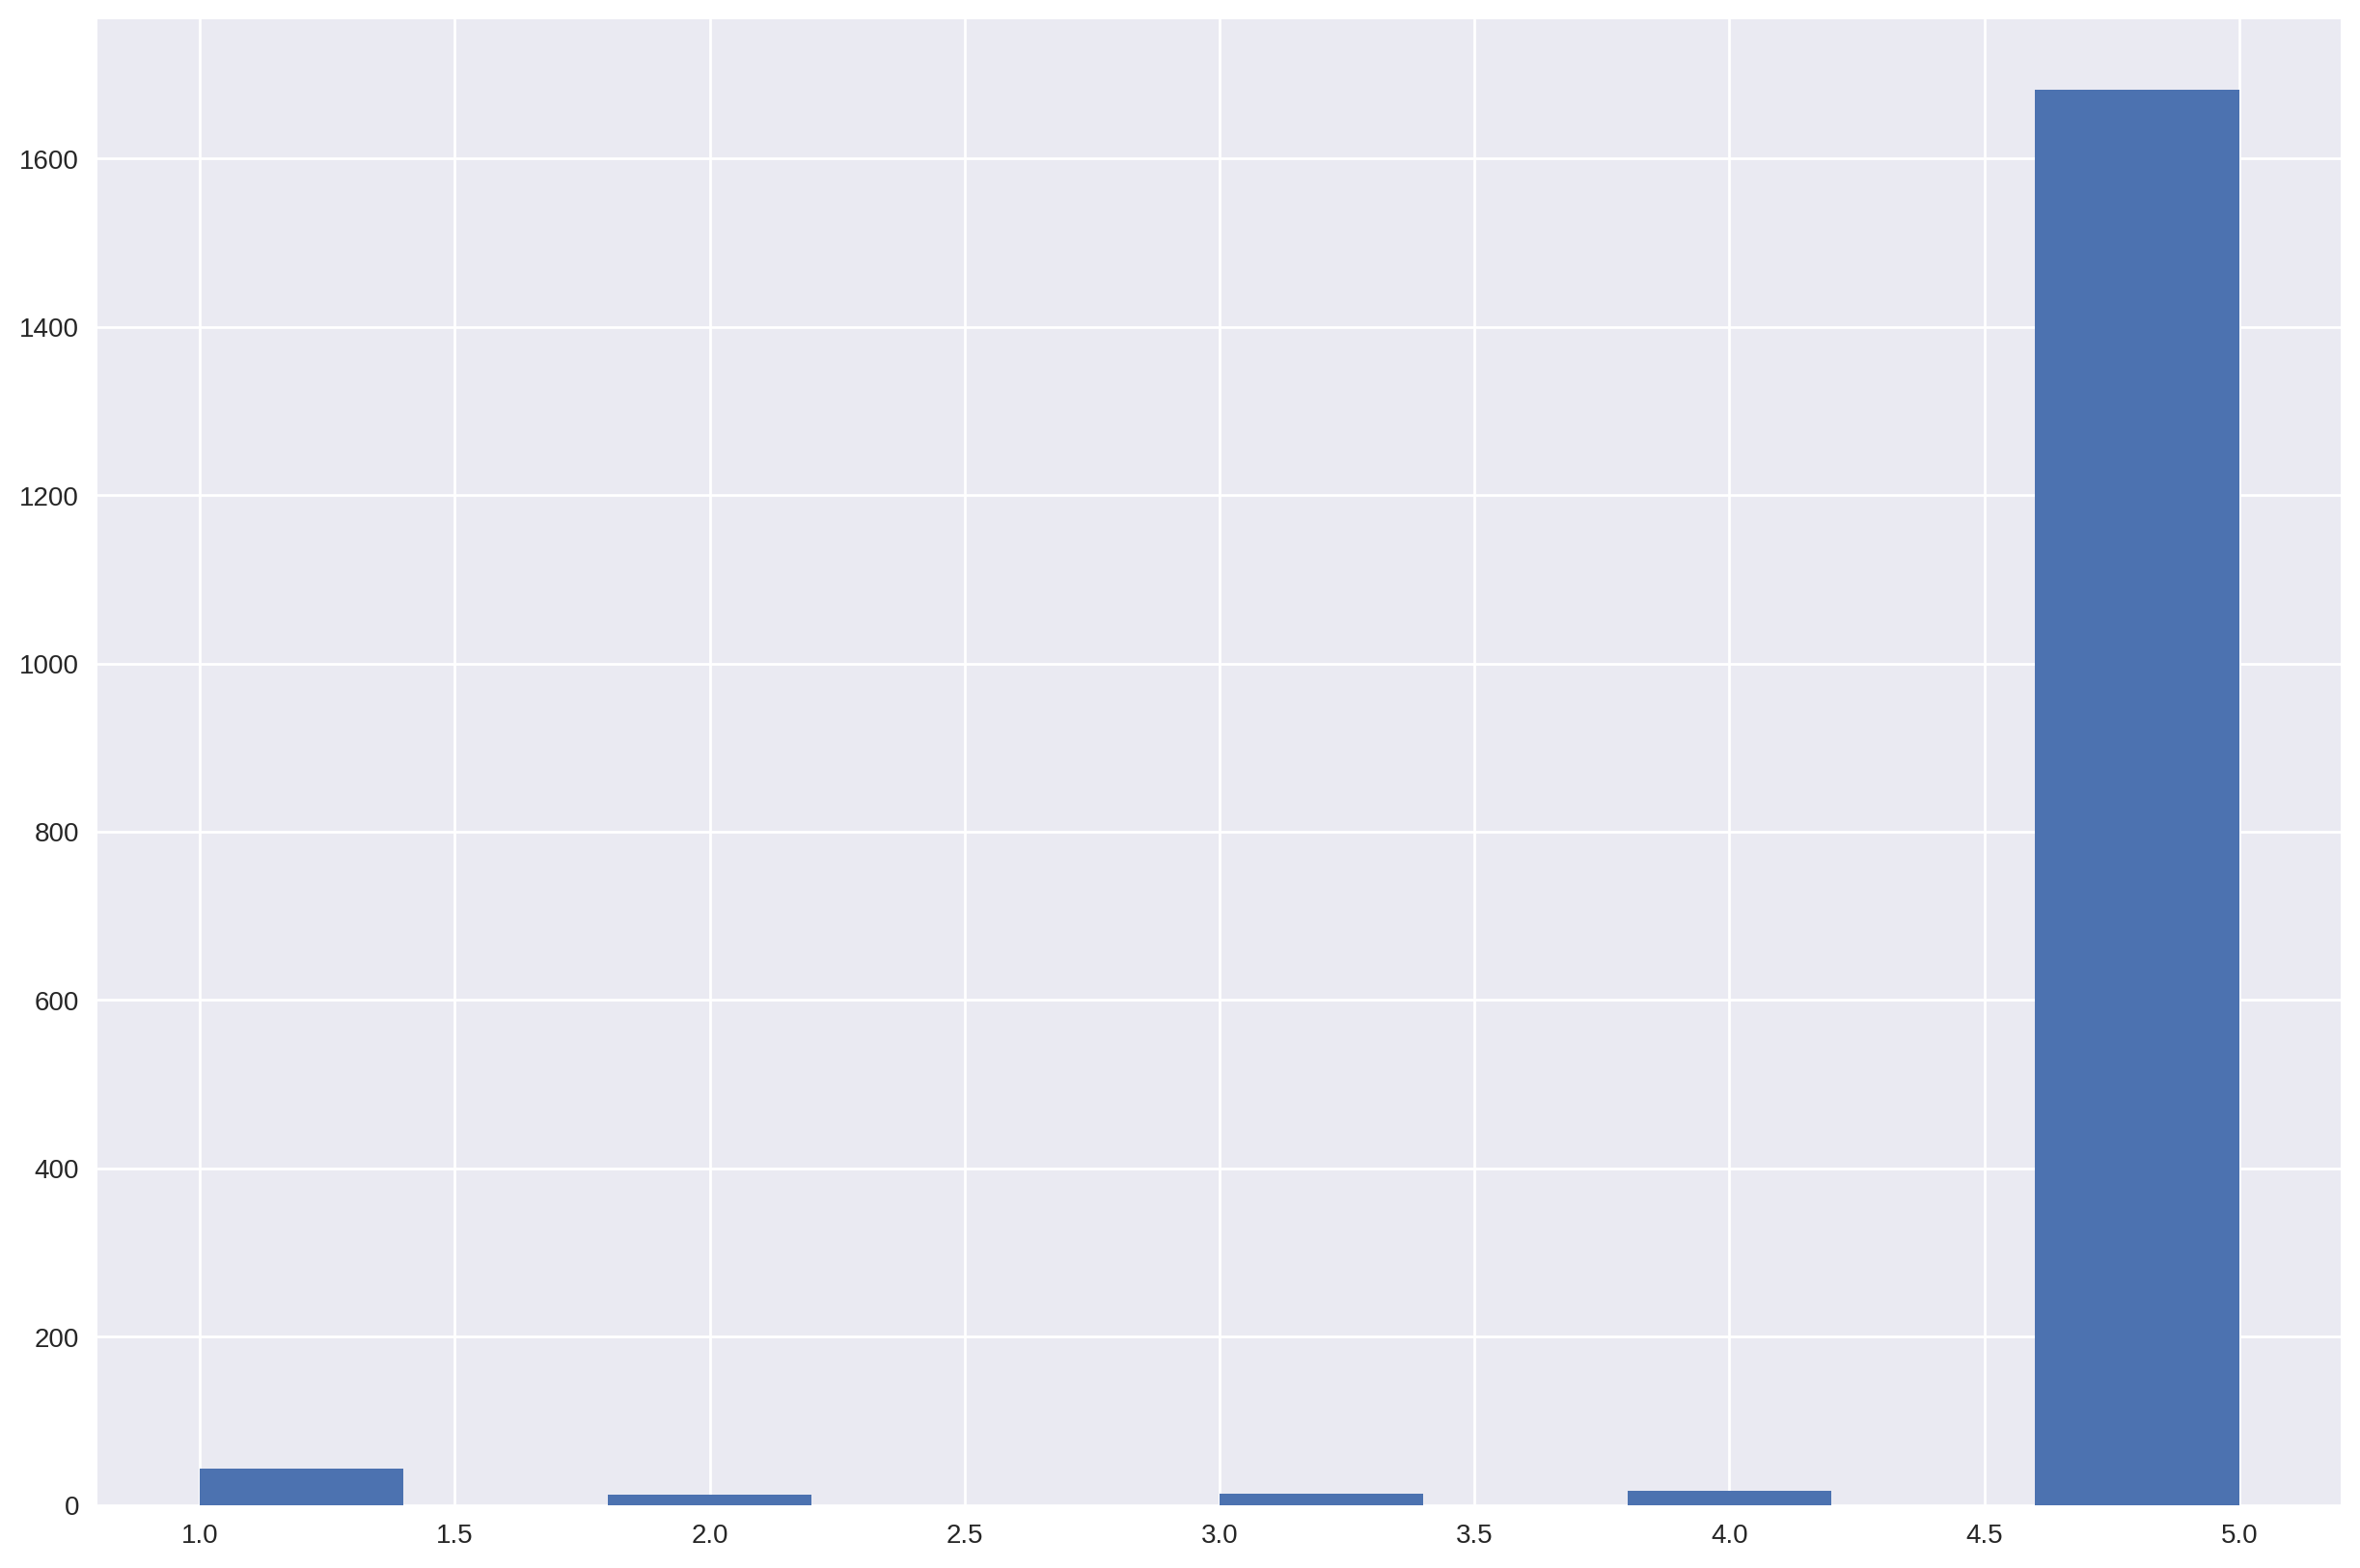

In [12]:
plt.hist(df_yesdokrev['score'])
plt.show()

In [15]:
#DATA PREPROCESSING
# Lower casing

# Change the reviews type to string
df_yesdokrev['content'] = df_yesdokrev['content'].astype(str)# Before lowercasing
# Before lowercasing
print(df_yesdokrev['content'][1766])

Helpfull ☺☺


In [16]:
#Lowercase all reviews to see the difference
df_yesdokrev['content']= df_yesdokrev['content'].apply(lambda x: x.lower())
print(df_yesdokrev['content'][1766])

helpfull ☺☺


In [17]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [18]:
#edited from https://www.tensorscience.com/nlp/sentiment-analysis-tutorial-in-python-classifying-reviews-on-movies-and-products
import string

df_yesdokrev['wordCount'] = [len(review.split()) for review in df_yesdokrev['content']]

df_yesdokrev['uppercaseCharCount'] = [sum(char.isupper() for char in review) \
                              for review in df_yesdokrev['content']]

df_yesdokrev['specialCharCount'] = [sum(char in string.punctuation for char in review) \
                            for review in df_yesdokrev['content']]

In [19]:
df_yesdokrev.loc[:,["content","score","sentiment_polarity", "sentiment_subjective","wordCount","uppercaseCharCount","specialCharCount"]]

,content,score,sentiment_polarity,sentiment_subjective,wordCount,uppercaseCharCount,specialCharCount
0,very limited insurance integration options,3,-0.092857,0.185714,5,0,0
1,so hard,1,-0.291667,0.541667,2,0,0
2,bagus,5,0.000000,0.000000,1,0,0
3,saya nggak bisa login asuransi saya di app ini,1,0.000000,0.000000,9,0,0
4,"hati2 dokter2 disini..konsultasi krn positif covid, bilang mau ksh obat antivirus movflor malahan tdk dikasih apa2,bahkan vitamin pun tdk diresepkan...tdk ada resep dokternya",1,0.000000,0.000000,23,0,7
...,...,...,...,...,...,...,...
1762,"berguna banget, lagi sakit perut tengah malem ga tau kenapa tinggal telpon dokter langsung dijelasin kenapa dan langkah penyembuhan yang perlu diambil, sangat akurat informasinya",5,0.000000,0.000000,25,0,2
1763,nice app,5,0.600000,1.000000,2,0,0
1764,very good,5,0.910000,0.780000,2,0,0
1765,"dokternya membantu, aplikasi mudah digunakan, bisa dipake kapan dan dimana aja",5,0.000000,0.000000,11,0,2


In [20]:
#Removing stopwords
#Using nltk
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize, sent_tokenize
from nltk import FreqDist
from nltk.corpus import stopwords, wordnet
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer


from wordcloud import WordCloud, STOPWORDS
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

from string import punctuation

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.callbacks import EarlyStopping


In [21]:
# function to plot most frequent terms
def freq_words(x, terms = 30):
  all_words = ' '.join([text for text in x])
  all_words = all_words.split()

  fdist = FreqDist(all_words)
  words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})

  # selecting top 20 most frequent words
  d = words_df.nlargest(columns="count", n = terms)
  plt.figure(figsize=(20,5))
  ax = sns.barplot(data=d, x= "word", y = "count")
  ax.set(ylabel = 'Count')
  plt.show()

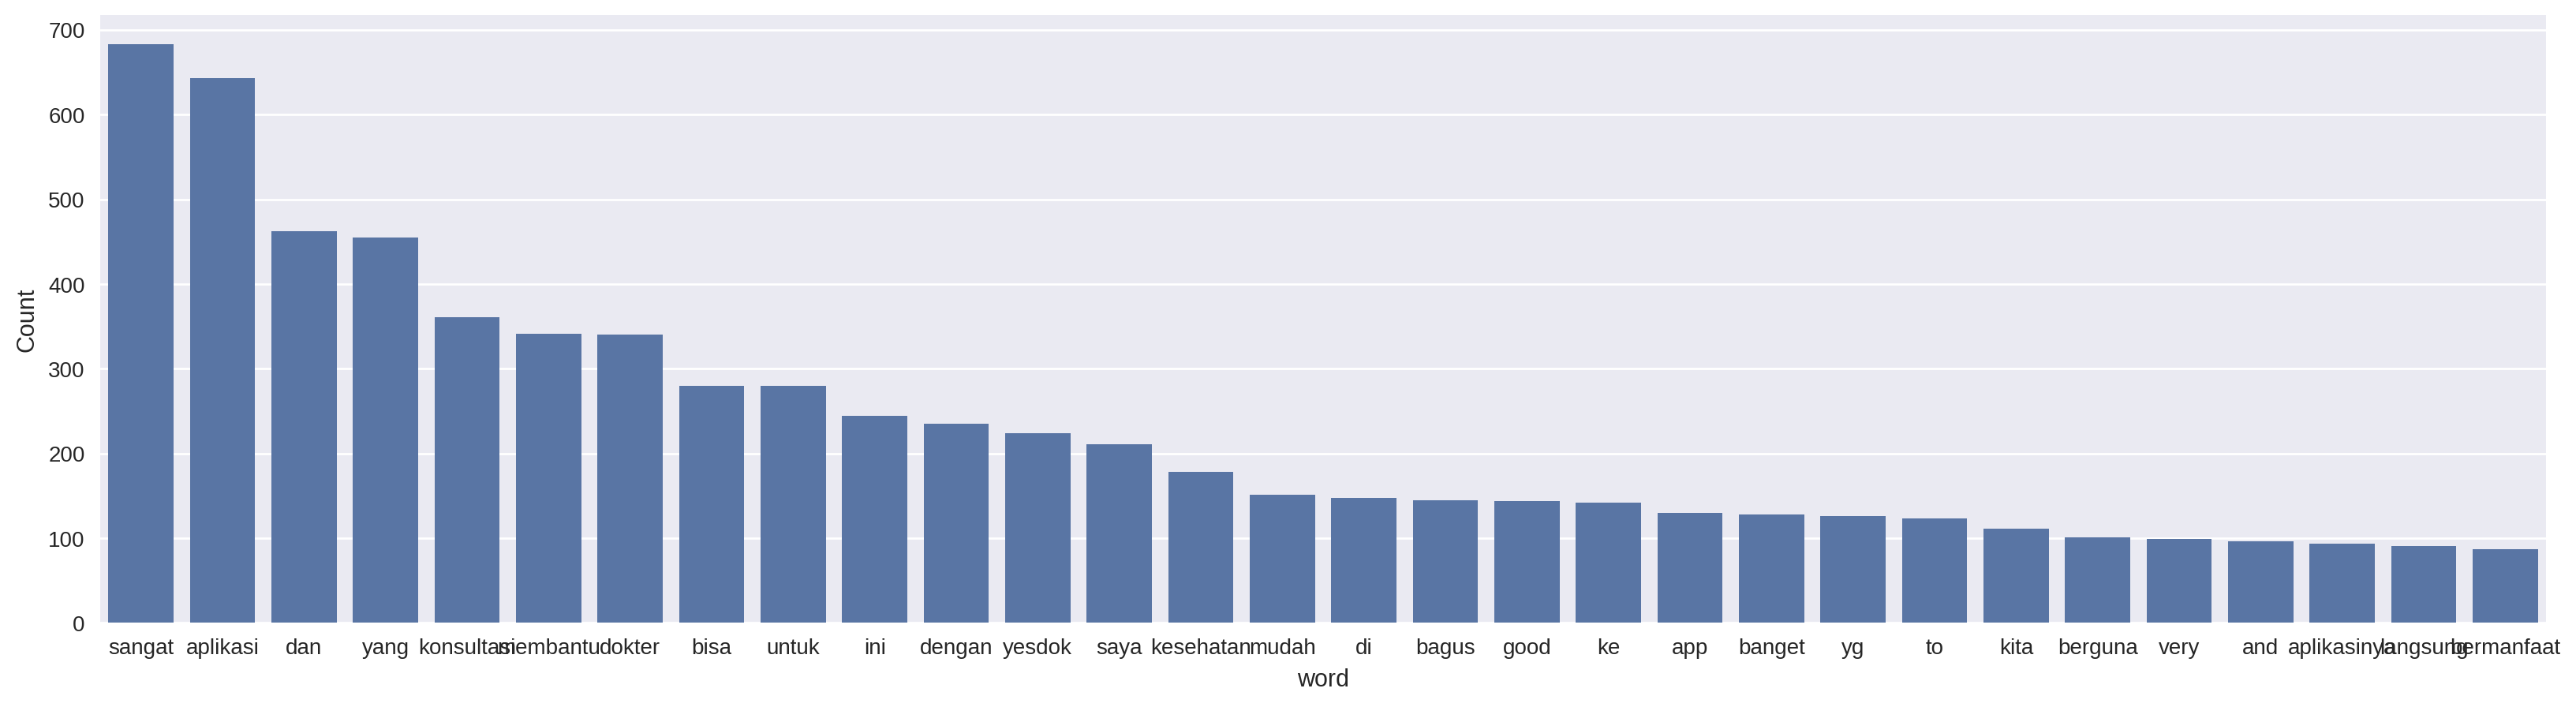

In [22]:
freq_words(df_yesdokrev['content'])

In [23]:
#check if there is any special character
alphabet = string.ascii_letters+string.punctuation
print(df_yesdokrev.content.str.strip(alphabet).astype(bool).any())

extracted_emojis=[]

def extract_emojis(s):
    expe = re.compile('[\U00010000-\U0010ffff]', flags=re.UNICODE)
    return expe.findall(s)
    return expe.sub(r'',s)

for y in df_yesdokrev['content']:
    #print(str(extract_emojis(y)))
    extracted_emojis.append(str(extract_emojis(y)))

print(extracted_emojis)

True
['[]', '[]', '[]', '[]', '[]', '[]', '[]', "['👎']", "['👍']", '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', "['😭']", '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', "['👍', '👍']", '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', "['👍', '🏻']", '[]', '[]', '[]', '[]', '[]', '[]', '[]', "['👍']", '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', "['👍']", '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]

In [24]:
df_yesdokrev.loc[:,["content","score","sentiment_polarity", "sentiment_subjective","wordCount","uppercaseCharCount","specialCharCount"]]

,content,score,sentiment_polarity,sentiment_subjective,wordCount,uppercaseCharCount,specialCharCount
0,very limited insurance integration options,3,-0.092857,0.185714,5,0,0
1,so hard,1,-0.291667,0.541667,2,0,0
2,bagus,5,0.000000,0.000000,1,0,0
3,saya nggak bisa login asuransi saya di app ini,1,0.000000,0.000000,9,0,0
4,"hati2 dokter2 disini..konsultasi krn positif covid, bilang mau ksh obat antivirus movflor malahan tdk dikasih apa2,bahkan vitamin pun tdk diresepkan...tdk ada resep dokternya",1,0.000000,0.000000,23,0,7
...,...,...,...,...,...,...,...
1762,"berguna banget, lagi sakit perut tengah malem ga tau kenapa tinggal telpon dokter langsung dijelasin kenapa dan langkah penyembuhan yang perlu diambil, sangat akurat informasinya",5,0.000000,0.000000,25,0,2
1763,nice app,5,0.600000,1.000000,2,0,0
1764,very good,5,0.910000,0.780000,2,0,0
1765,"dokternya membantu, aplikasi mudah digunakan, bisa dipake kapan dan dimana aja",5,0.000000,0.000000,11,0,2


In [25]:
#Add a column name polarity_rating from changing the score of the review into 3 labels: Pos, Negative Neutral
df_yesdokrev['sentiment_rating'] = df_yesdokrev['score'].apply(lambda x: 'Positive' if x > 3 else('Neutral' if x == 3  else 'Negative'))

In [26]:
df_yesdokrev.loc[:,["content","score","sentiment_polarity", "sentiment_subjective","sentiment_rating"]]

,content,score,sentiment_polarity,sentiment_subjective,sentiment_rating
0,very limited insurance integration options,3,-0.092857,0.185714,Neutral
1,so hard,1,-0.291667,0.541667,Negative
2,bagus,5,0.000000,0.000000,Positive
3,saya nggak bisa login asuransi saya di app ini,1,0.000000,0.000000,Negative
4,"hati2 dokter2 disini..konsultasi krn positif covid, bilang mau ksh obat antivirus movflor malahan tdk dikasih apa2,bahkan vitamin pun tdk diresepkan...tdk ada resep dokternya",1,0.000000,0.000000,Negative
...,...,...,...,...,...
1762,"berguna banget, lagi sakit perut tengah malem ga tau kenapa tinggal telpon dokter langsung dijelasin kenapa dan langkah penyembuhan yang perlu diambil, sangat akurat informasinya",5,0.000000,0.000000,Positive
1763,nice app,5,0.600000,1.000000,Positive
1764,very good,5,0.910000,0.780000,Positive
1765,"dokternya membantu, aplikasi mudah digunakan, bisa dipake kapan dan dimana aja",5,0.000000,0.000000,Positive


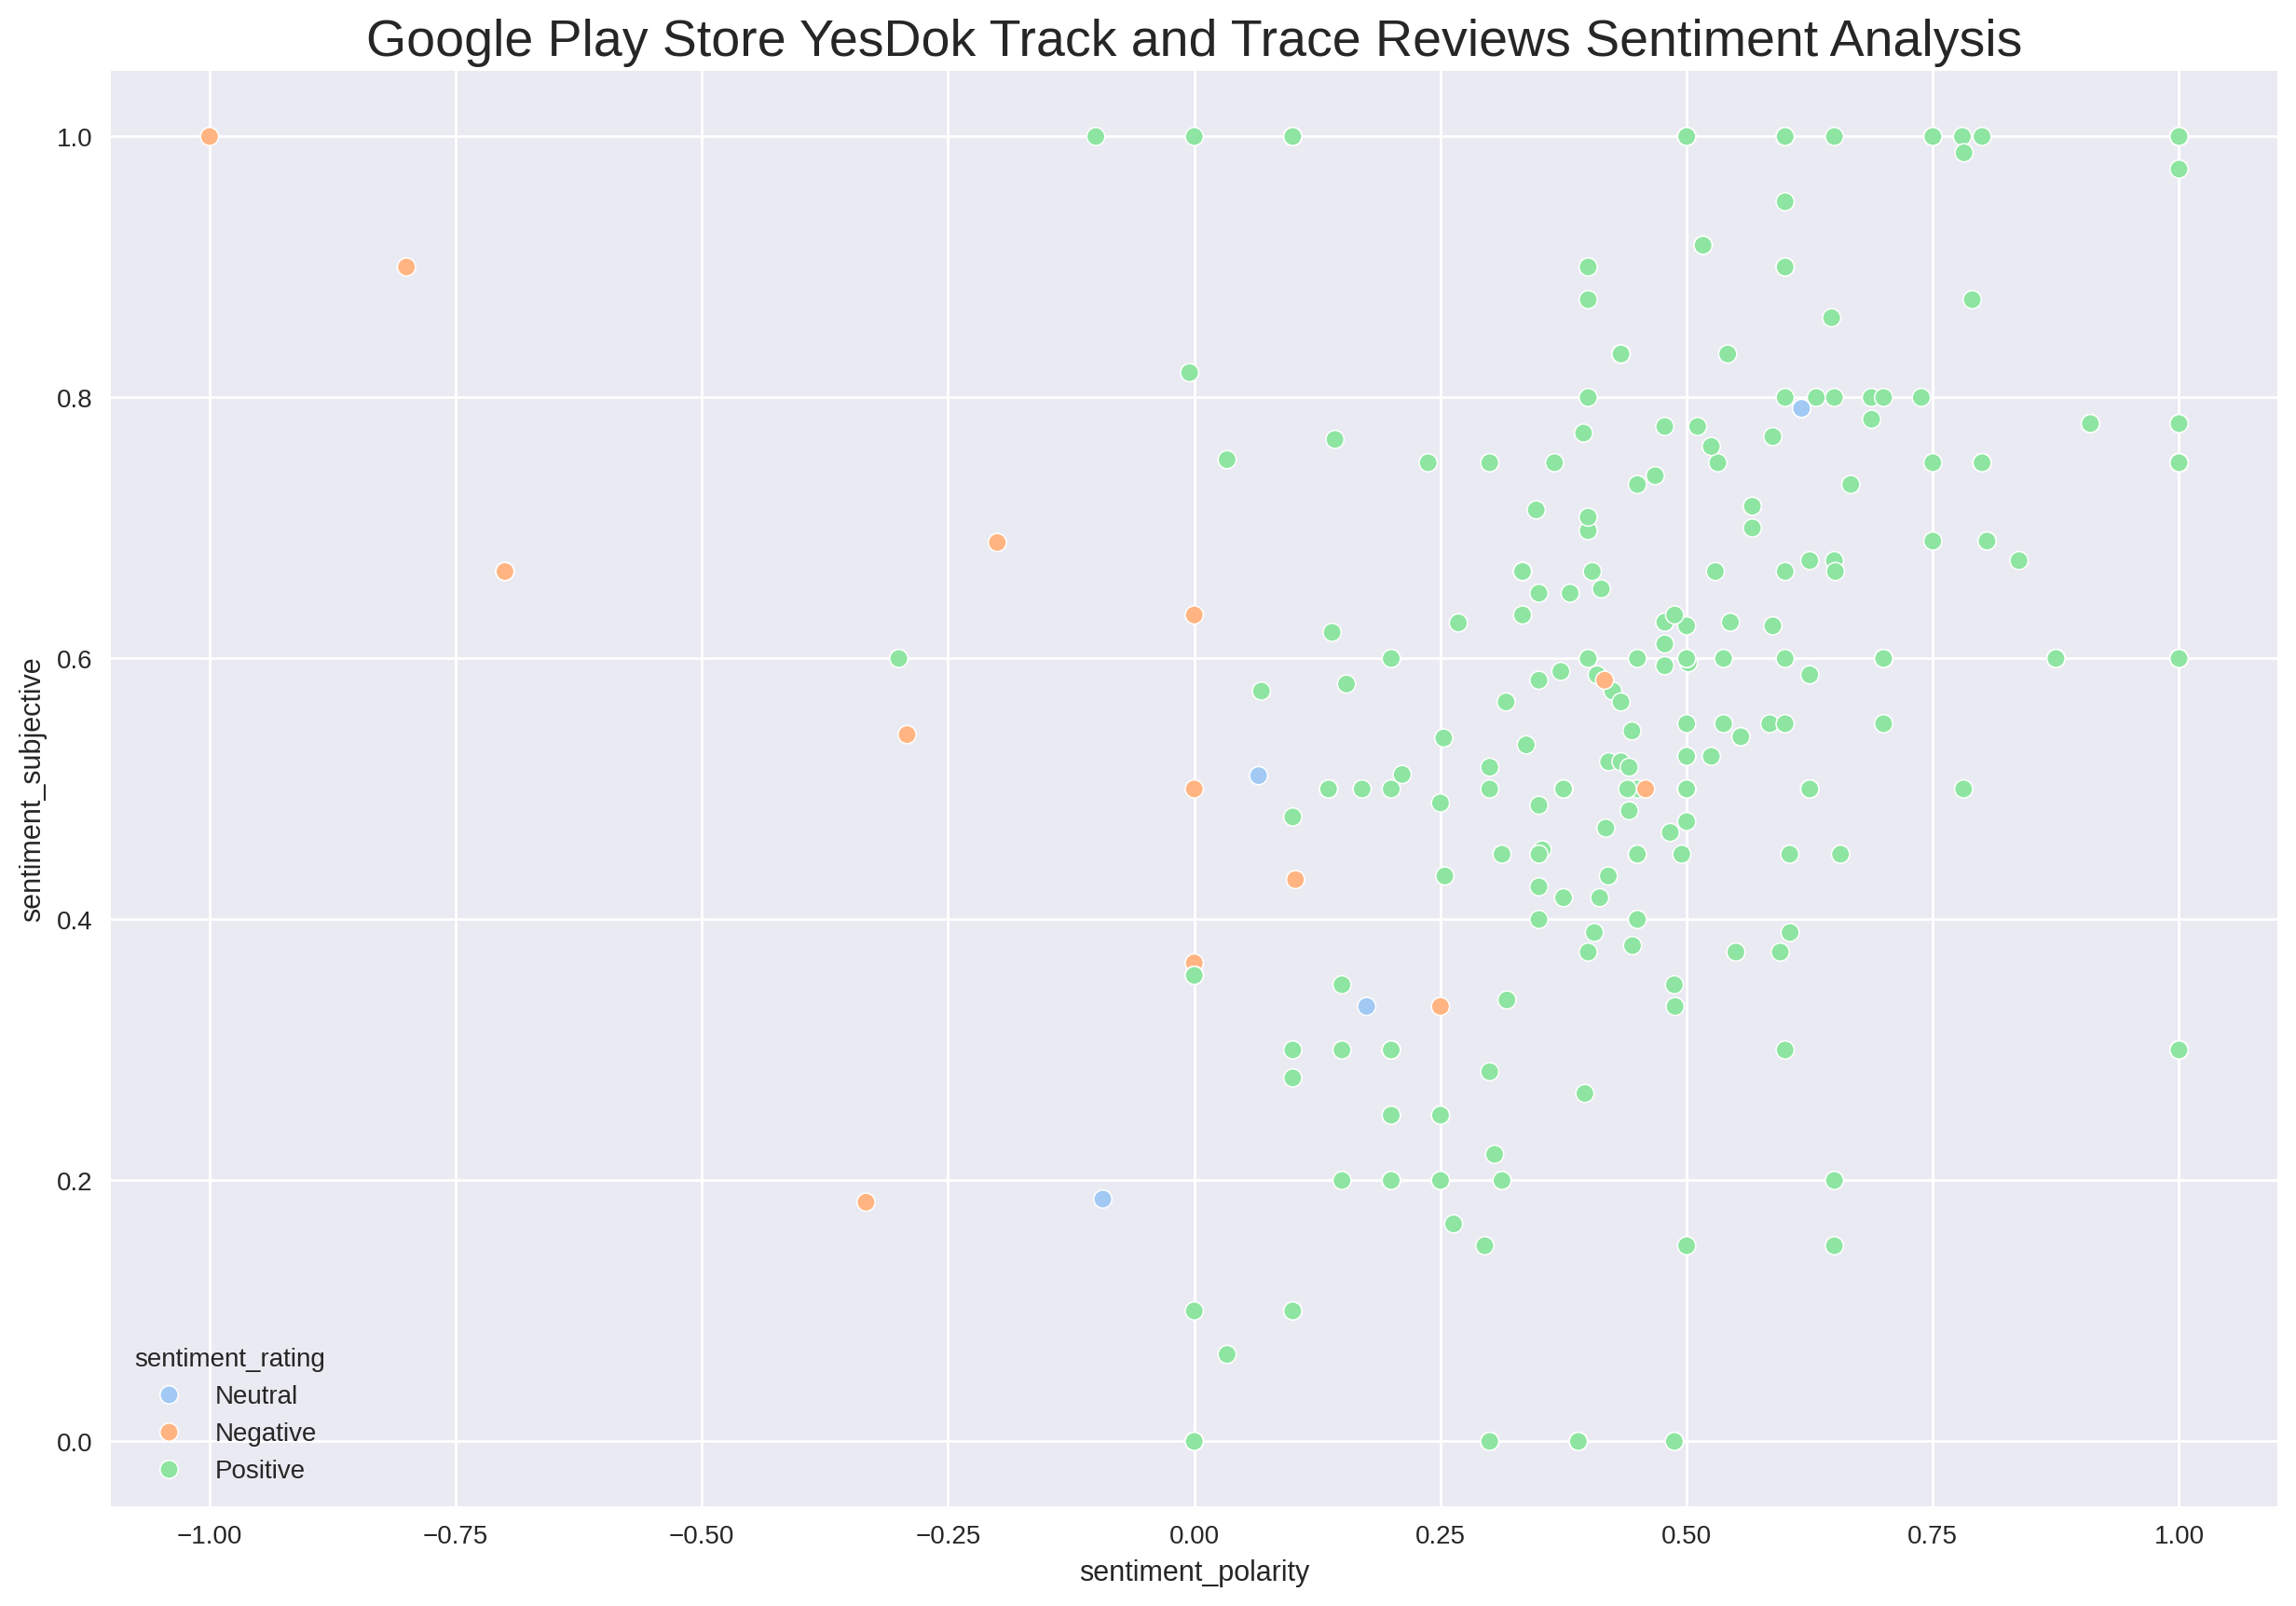

In [29]:
# import matplotlib.pyplot as plt
# import seaborn as sns
# plt.figure(figsize=(15, 10))
# sns.scatterplot(df_yesdokrev['sentiment_polarity'], df_yesdokrev['sentiment_subjective'],
#                 hue = df_yesdokrev['sentiment_rating'], edgecolor='white', palette="pastel")
# plt.title("Google Play Store YesDok Track and Trace Reviews Sentiment Analysis", fontsize=20)
# plt.show()

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15, 10))

# Use the 'data' argument to pass the DataFrame and specify 'x' and 'y' within the function call
sns.scatterplot(data=df_yesdokrev, x='sentiment_polarity', y='sentiment_subjective',
                hue='sentiment_rating', edgecolor='white', palette="pastel")

plt.title("Google Play Store YesDok Track and Trace Reviews Sentiment Analysis", fontsize=20)
plt.show()

In [31]:
#Print the extracted emojis review column (content) before stopwords
df_yesdokrev.to_csv(r'E:\df_yesdokrev_before_stopwords_sentiment_rating.csv', index = False)

In [32]:
import nltk
from nltk.corpus import stopwords
stop = stopwords.words('english') + ["someone","still","would","need"]
print(stop)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [33]:
print(len(stop))

183


In [34]:
df_yesdokrev_stopwords = df_yesdokrev.loc[:,["content","score","sentiment_polarity", "sentiment_subjective","sentiment_rating"]]

In [35]:
# Exclude stopwords
df_yesdokrev_stopwords['tweet_without_stopwords'] = df_yesdokrev_stopwords['content'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
print(df_yesdokrev_stopwords)

                                                                                                                                                                                 content  \
0                                                                                                                                             very limited insurance integration options   
1                                                                                                                                                                                so hard   
2                                                                                                                                                                                  bagus   
3                                                                                                                                         saya nggak bisa login asuransi saya di app ini   
4         hati2 dokter2 disini..konsultasi krn positif covid

In [36]:
pat = r'\b(?:{})\b'.format('|'.join(stop))
df_yesdokrev_stopwords['tweet_without_stopwords'] = df_yesdokrev_stopwords['content'].str.replace(pat, '')
df_yesdokrev_stopwords['tweet_without_stopwords'] = df_yesdokrev_stopwords['tweet_without_stopwords'].str.replace(r'\s+', ' ')

In [37]:
#Save into csv after applying stopwords
df_yesdokrev_stopwords.to_csv(r'E:\df_yesdokrev_after_stopwords_sentiment_rating2.csv', index = False)

In [38]:
#Count after stopwords
#edited from https://www.tensorscience.com/nlp/sentiment-analysis-tutorial-in-python-classifying-reviews-on-movies-and-products
import string

df_yesdokrev_stopwords['wordCount'] = [len(review.split()) for review in df_yesdokrev_stopwords['content']]
df_yesdokrev_stopwords['wordCount_after_stopwords'] = [len(review.split()) for review in df_yesdokrev_stopwords['tweet_without_stopwords']]


In [39]:
df_yesdokrev_stopwords.loc[:,["content","score","sentiment_polarity", "sentiment_rating","wordCount","tweet_without_stopwords", "wordCount_after_stopwords"]]

,content,score,sentiment_polarity,sentiment_rating,wordCount,tweet_without_stopwords,wordCount_after_stopwords
0,very limited insurance integration options,3,-0.092857,Neutral,5,very limited insurance integration options,5
1,so hard,1,-0.291667,Negative,2,so hard,2
2,bagus,5,0.000000,Positive,1,bagus,1
3,saya nggak bisa login asuransi saya di app ini,1,0.000000,Negative,9,saya nggak bisa login asuransi saya di app ini,9
4,"hati2 dokter2 disini..konsultasi krn positif covid, bilang mau ksh obat antivirus movflor malahan tdk dikasih apa2,bahkan vitamin pun tdk diresepkan...tdk ada resep dokternya",1,0.000000,Negative,23,"hati2 dokter2 disini..konsultasi krn positif covid, bilang mau ksh obat antivirus movflor malahan tdk dikasih apa2,bahkan vitamin pun tdk diresepkan...tdk ada resep dokternya",23
...,...,...,...,...,...,...,...
1762,"berguna banget, lagi sakit perut tengah malem ga tau kenapa tinggal telpon dokter langsung dijelasin kenapa dan langkah penyembuhan yang perlu diambil, sangat akurat informasinya",5,0.000000,Positive,25,"berguna banget, lagi sakit perut tengah malem ga tau kenapa tinggal telpon dokter langsung dijelasin kenapa dan langkah penyembuhan yang perlu diambil, sangat akurat informasinya",25
1763,nice app,5,0.600000,Positive,2,nice app,2
1764,very good,5,0.910000,Positive,2,very good,2
1765,"dokternya membantu, aplikasi mudah digunakan, bisa dipake kapan dan dimana aja",5,0.000000,Positive,11,"dokternya membantu, aplikasi mudah digunakan, bisa dipake kapan dan dimana aja",11


In [40]:
# function to plot most frequent terms
def freq_words(x, terms = 30):
  all_words = ' '.join([text for text in x])
  all_words = all_words.split()

  fdist = FreqDist(all_words)
  words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})

  # selecting top 20 most frequent words
  d = words_df.nlargest(columns="count", n = terms)
  plt.figure(figsize=(20,5))
  ax = sns.barplot(data=d, x= "word", y = "count")
  ax.set(ylabel = 'Count')
  plt.show()

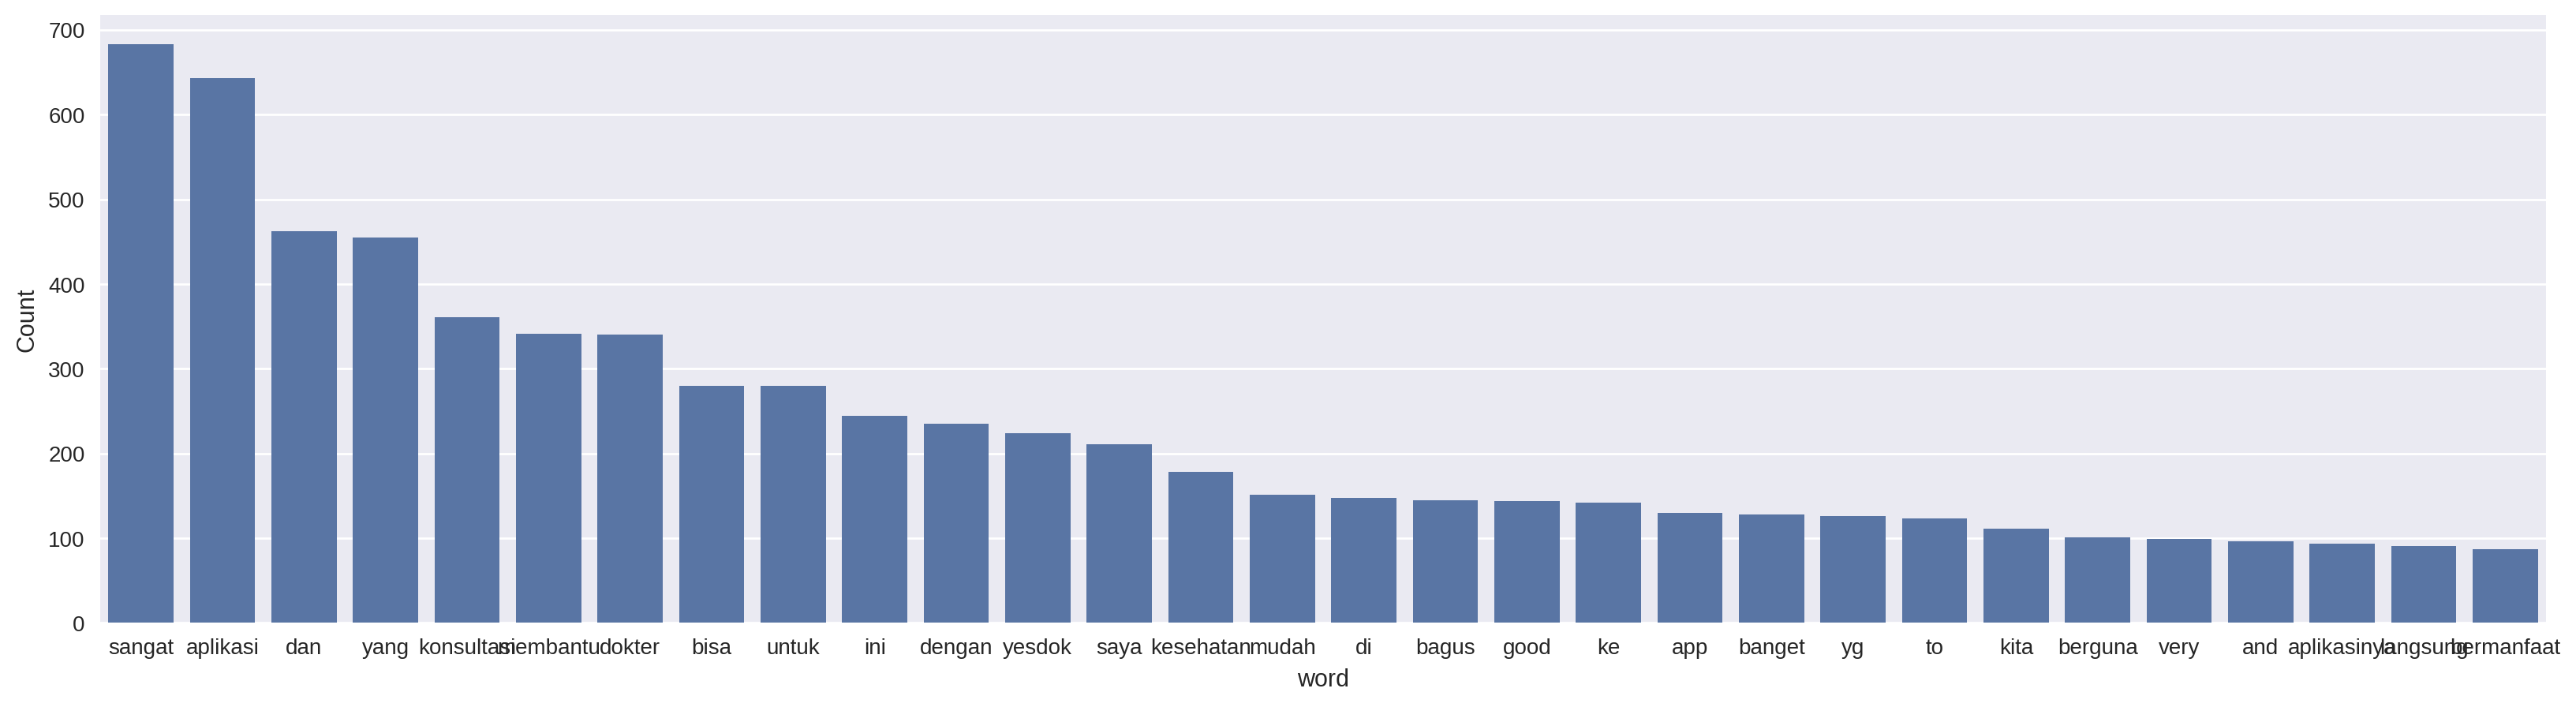

In [41]:
freq_words(df_yesdokrev_stopwords['tweet_without_stopwords'])

In [42]:
newStopWords = ["'",".",",", "someone","still","would","need"]

#from nltk.corpus import stopwords
#stoplist = stopwords.words('english') + ['though']

#NOT YET DONE ==== 24 May 2022

In [44]:
#Stemming

#Stemming function chops off the end of the word
#and transform the word into its root form.
#All suffixes like -s, -es, -ed, -ing are removed.

def stemming(x):
    st = PorterStemmer()
    if x is not None:
       for word in x.split():
           st.stem(word)

df_yesdokrev_stopwords['tweet_without_stopwords'].apply(lambda x:stemming(x))
print(df_yesdokrev_stopwords['tweet_without_stopwords'][1766])

helpfull ☺☺


In [45]:
#===BIGRAM https://towardsdatascience.com/text-analysis-basics-in-python-443282942ec5 not yet
#Creating bigram/trigram to search

In [46]:
#DROP NA
df_yesdokrev_stopwords.dropna(inplace=True)
df_yesdokrev_stopwords.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1767 entries, 0 to 1766
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   content                    1767 non-null   object 
 1   score                      1767 non-null   int64  
 2   sentiment_polarity         1767 non-null   float64
 3   sentiment_subjective       1767 non-null   float64
 4   sentiment_rating           1767 non-null   object 
 5   tweet_without_stopwords    1767 non-null   object 
 6   wordCount                  1767 non-null   int64  
 7   wordCount_after_stopwords  1767 non-null   int64  
dtypes: float64(2), int64(3), object(3)
memory usage: 110.6+ KB


In [47]:
df_yesdokrev_stopwords.loc[:,["content","score","sentiment_rating","wordCount","tweet_without_stopwords", "wordCount_after_stopwords"]]

,content,score,sentiment_rating,wordCount,tweet_without_stopwords,wordCount_after_stopwords
0,very limited insurance integration options,3,Neutral,5,very limited insurance integration options,5
1,so hard,1,Negative,2,so hard,2
2,bagus,5,Positive,1,bagus,1
3,saya nggak bisa login asuransi saya di app ini,1,Negative,9,saya nggak bisa login asuransi saya di app ini,9
4,"hati2 dokter2 disini..konsultasi krn positif covid, bilang mau ksh obat antivirus movflor malahan tdk dikasih apa2,bahkan vitamin pun tdk diresepkan...tdk ada resep dokternya",1,Negative,23,"hati2 dokter2 disini..konsultasi krn positif covid, bilang mau ksh obat antivirus movflor malahan tdk dikasih apa2,bahkan vitamin pun tdk diresepkan...tdk ada resep dokternya",23
...,...,...,...,...,...,...
1762,"berguna banget, lagi sakit perut tengah malem ga tau kenapa tinggal telpon dokter langsung dijelasin kenapa dan langkah penyembuhan yang perlu diambil, sangat akurat informasinya",5,Positive,25,"berguna banget, lagi sakit perut tengah malem ga tau kenapa tinggal telpon dokter langsung dijelasin kenapa dan langkah penyembuhan yang perlu diambil, sangat akurat informasinya",25
1763,nice app,5,Positive,2,nice app,2
1764,very good,5,Positive,2,very good,2
1765,"dokternya membantu, aplikasi mudah digunakan, bisa dipake kapan dan dimana aja",5,Positive,11,"dokternya membantu, aplikasi mudah digunakan, bisa dipake kapan dan dimana aja",11
